In [1]:
!pip install rdkit

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

# بخش آ

In [2]:
df = pd.read_csv('BBBP.csv', )

In [3]:
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [4]:
# def smiles_len(smiles_: str):
#     l = 0
#     for i, c in enumerate(smiles_):
#         if i<len(smiles_)-1:
#             if c=='S' and smiles_[i+1]=='i':
#                 continue
#             elif c=='C' and smiles_[i+1]=='l':
#                 continue
#             elif c=='B' and smiles_[i+1]=='r':
#                 continue
#         l+=1
#     return l
df['smiles_length'] = df['smiles'].apply(lambda x: len(x))

In [5]:
def calculate_mw(smiles):
    """
        This function calculates the weight of the molecules
    """
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol) if mol is not None else None

# Function to calculate number of atoms
def calculate_num_atoms(smiles):
    """
        This function calculates the number of atoms in the molecule
    """
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms() if mol is not None else None

df['molecular_weight'] = df['smiles'].apply(calculate_mw)
df['num_atoms'] = df['smiles'].apply(calculate_num_atoms)

[17:49:41] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] WARNING: not removing hydrogen atom without neighbors
[17:49:41] Explicit valence for atom # 11 N, 4, is greater than pe

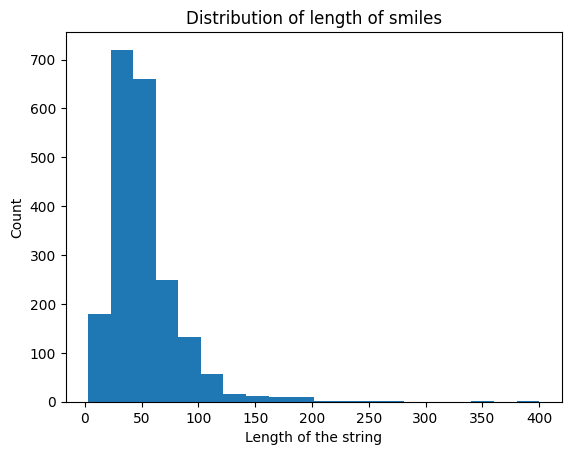

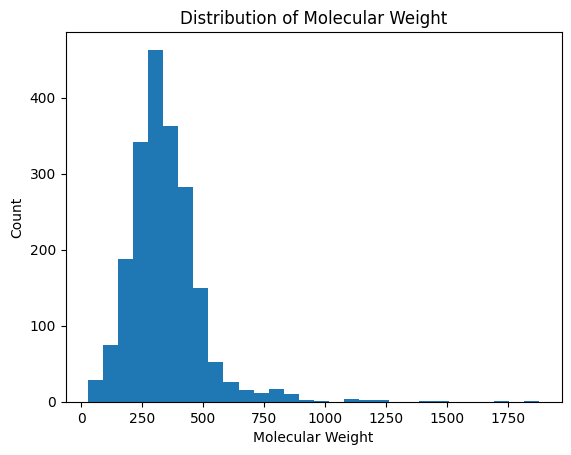

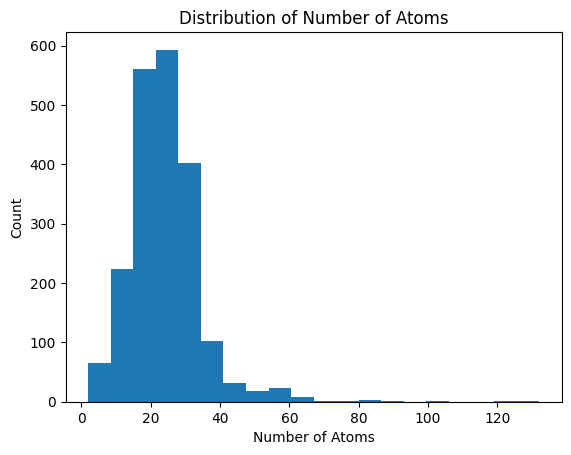

maximum length of the series: 400


In [6]:
# Plot histogram for number of atoms
plt.hist(df['smiles_length'], bins=20)
plt.xlabel('Length of the string')
plt.ylabel('Count')
plt.title('Distribution of length of smiles')
plt.show()

# Plot histogram for molecular weight
plt.hist(df['molecular_weight'].dropna(), bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Count')
plt.title('Distribution of Molecular Weight')
plt.show()

# Plot histogram for number of atoms
plt.hist(df['num_atoms'].dropna(), bins=20)
plt.xlabel('Number of Atoms')
plt.ylabel('Count')
plt.title('Distribution of Number of Atoms')
plt.show()

print(f"maximum length of the series: {max(df['smiles_length'])}")

As you can see in the above figures, the avg length of smile strings is 50 characters and most of the data is distributed around it with a low std. However, there are a few very large sequences as well (~400 chars)

### Tokenizing

In [7]:
# all_smiles = ''.join(df['smiles'])

# def smiles_chars(smiles_: str):
#     l = set()
#     pend = False
#     for i, c in enumerate(smiles_):
#         if pend:
#             l.add(f"{smiles_[i-1]}{c}")
#             pend = False
#             continue

#         if i<len(smiles_)-1:
#             if c=='S' and smiles_[i+1]=='i':
#                 pend = True
#                 continue
#             elif c=='C' and smiles_[i+1]=='l':
#                 pend = True
#                 continue
#             elif c=='B' and smiles_[i+1]=='r':
#                 pend = True
#                 continue
#         l.add(c)

#     return l

# smiles_chars(all_smiles)

{'#',
 '%',
 '(',
 ')',
 '+',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 '@',
 'B',
 'Br',
 'C',
 'Cl',
 'F',
 'H',
 'I',
 'N',
 'O',
 'P',
 'S',
 '[',
 '\\',
 ']',
 'a',
 'c',
 'n',
 'o',
 's'}

In [8]:
all_smiles = ''.join(df['smiles'])
tokens = list(set(all_smiles))

token_counts = {token: all_smiles.count(token) for token in tokens}

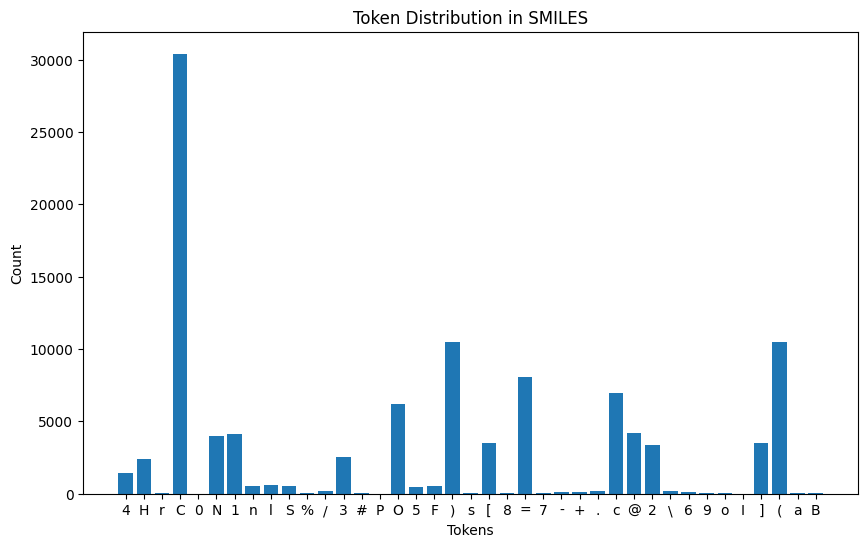

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(token_counts.keys(), token_counts.values())
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.title('Token Distribution in SMILES')
plt.show()

# بخش ب

In [10]:
token_to_index = {token: idx for idx, token in enumerate(tokens)}
index_to_token = {idx: token for token, idx in token_to_index.items()}

In [11]:
max(df['smiles_length'])

400

In [12]:
def encode_smiles(smiles):
    encoded = torch.zeros(max(df['smiles_length']), len(tokens))
    for i, char in enumerate(smiles):
        encoded[i][token_to_index[char]] = 1
    return encoded

# Encode all SMILES strings
encoded_smiles = [(encode_smiles(item.smiles), item.p_np) for _, item in df[['p_np', 'smiles']].iterrows()]

In [13]:
# for i, item in df[['p_np', 'smiles']].iterrows():
#     print(item.smiles)
#     break

[Cl].CC(C)NCC(O)COc1cccc2ccccc12


In [16]:
len(encoded_smiles)

2050

In [17]:
# def split_dataset(data):
#     val_ratio = 0.15
#     test_ratio = 0.15
#     test_size = int(test_ratio*len(data))
#     train_val_size = len(data) - test_size
#     train_val_dataset, test_dataset = random_split(data, [train_val_size, test_size])

#     validation_size = int(val_ratio*len(train_val_dataset))
#     train_size = len(train_val_dataset) - validation_size
#     train_dataset, val_dataset = random_split(train_val_dataset, [train_size, validation_size])
#     print(f"train size is {len(train_dataset)}")
#     print(f"validation size is {len(val_dataset)}")
#     print(f"test size is {len(test_dataset)}")
#     return train_dataset, val_dataset, test_dataset

In [18]:
def split_dataset_test(data):
    test_ratio = 0.15
    test_size = int(test_ratio*len(data))
    train_val_size = len(data) - test_size
    train_val_dataset, test_dataset = random_split(data, [train_val_size, test_size])

    print(f"train size is {len(train_val_dataset)}")
    print(f"test size is {len(test_dataset)}")
    return train_val_dataset, test_dataset

In [19]:
train_val_dataset, test_dataset = split_dataset_test(encoded_smiles)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

train size is 1743
test size is 307


In [20]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(0.0)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc2.bias.data.fill_(0.0)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        out = x.view(x.shape[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [21]:
def train(model, train_loader, val_loader, epochs, optimizer, loss_function) -> (list, list, list, list):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(f"running on {device}")
    model.to(device)
    model.train()

    train_loss_values = []
    train_accuracy_values = []
    val_loss_values = []
    val_accuracy_values = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        model.train()
        for i, data in enumerate(train_loader):

            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            # print(outputs)
            loss = loss_function(outputs, labels)
            # print(outputs)
            loss.backward()
            optimizer.step()

            # Calculate training loss
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct / total

        train_loss_values.append(epoch_train_loss)
        train_accuracy_values.append(epoch_train_accuracy)

        # print(f"Epoch [{epoch + 1}/{epochs}], "
        #     f"Train Loss: {epoch_train_loss:.4f}, "
        #     f"Train Accuracy: {100 * epoch_train_accuracy:.2f}%")

        if val_loader is not None:

            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_inputs)
                    val_loss = loss_function(val_outputs, val_labels)
                    val_running_loss += val_loss.item()
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()

            epoch_val_loss = val_running_loss / len(val_loader)
            epoch_val_accuracy = val_correct / val_total

            val_loss_values.append(epoch_val_loss)
            val_accuracy_values.append(epoch_val_accuracy)

            # print(f"Validation Loss: {epoch_val_loss:.4f}, "
            #     f"Validation Accuracy: {100 * epoch_val_accuracy:.2f}%")
    
    print(f"Train Loss: {train_loss_values[-1]:.4f}, "
            f"Train Accuracy: {100 * train_accuracy_values[-1]:.2f}%")
    print(f"Validation Loss: {val_loss_values[-1]:.4f}, "
            f"Validation Accuracy: {100 * val_accuracy_values[-1]:.2f}%")
    print("Finished Training")

    return train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values

def test(model, test_loader) -> float:

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_data in test_loader:
            test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
            test_outputs = model(test_inputs)
            _, test_predicted = test_outputs.max(1)
            test_total += test_labels.size(0)
            test_correct += test_predicted.eq(test_labels).sum().item()

    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {100 * test_accuracy:.2f}%")
    return test_accuracy


def plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values, epochs):

    # Plotting accuracy and loss per epoch
    plt.figure(figsize=(10, 5))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss_values, label='Training Loss')
    if val_loss_values is not None:
        plt.plot(range(1, epochs + 1), val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracy_values, label='Training Accuracy')
    if val_accuracy_values is not None:
        plt.plot(range(1, epochs + 1), val_accuracy_values, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [24]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

hidden_size = 128
output_size = 2
epochs = 15

train_acc = []
val_acc = []
test_acc = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split dataset into train and validation sets
    train_set = torch.utils.data.Subset(train_val_dataset, train_idx)
    val_set = torch.utils.data.Subset(train_val_dataset, val_idx)

    # Create dataloaders for train and validation sets
    train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=256, shuffle=False)
    input_size = encoded_smiles[0][0].shape[0] * encoded_smiles[0][0].shape[1]
    
    model_ = SimpleNN(input_size, hidden_size, output_size)
    criterion_ = nn.CrossEntropyLoss()
    optimizer_ = optim.Adam(model_.parameters(), lr=0.001)

    train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value = train(model=model_, train_loader=train_loader,
                                                                                        val_loader=val_loader, epochs=epochs, optimizer=optimizer_,
                                                                                        loss_function=criterion_)
    train_acc.append(train_accuracy_values[-1])
    val_acc.append(val_accuracy_value[-1])
    
    test_accuracy = test(model=model_, test_loader=test_loader)
    test_acc.append(test_accuracy)
    del model_
    torch.cuda.empty_cache()

print(f"train acc = {sum(train_acc)/num_folds}")
print(f"val acc = {sum(val_acc)/num_folds}")
print(f"test acc = {sum(test_acc)/num_folds}")

Fold 1/5
Train Loss: 0.0778, Train Accuracy: 97.85%
Validation Loss: 0.3087, Validation Accuracy: 85.67%
Finished Training
Test Accuracy: 86.32%
Fold 2/5
Train Loss: 0.0846, Train Accuracy: 97.63%
Validation Loss: 0.4062, Validation Accuracy: 84.81%
Finished Training
Test Accuracy: 85.02%
Fold 3/5
Train Loss: 0.0866, Train Accuracy: 97.27%
Validation Loss: 0.3877, Validation Accuracy: 83.38%
Finished Training
Test Accuracy: 85.99%
Fold 4/5
Train Loss: 0.0834, Train Accuracy: 97.99%
Validation Loss: 0.2867, Validation Accuracy: 88.51%
Finished Training
Test Accuracy: 86.32%
Fold 5/5
Train Loss: 0.0903, Train Accuracy: 97.35%
Validation Loss: 0.2869, Validation Accuracy: 87.64%
Finished Training
Test Accuracy: 87.62%
train acc = 0.9761903292657216
val acc = 0.8600352402595263
test acc = 0.8625407166123779


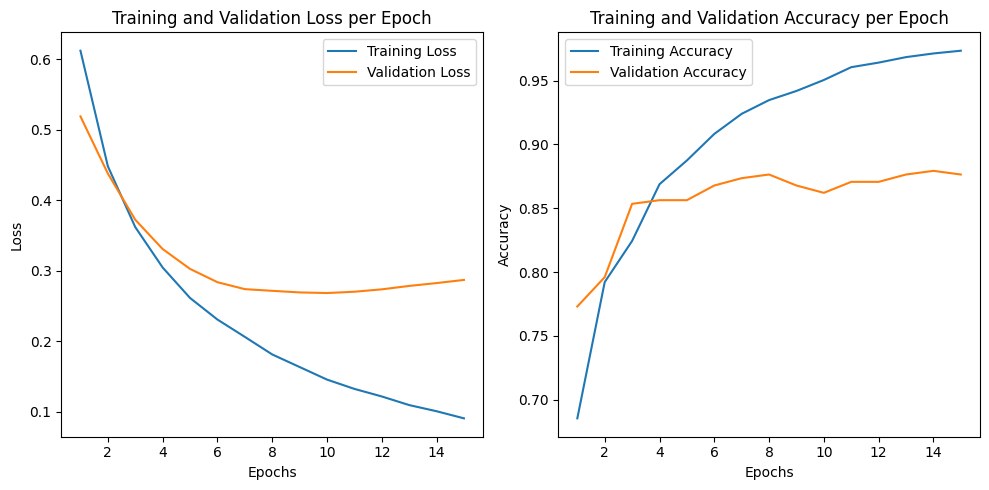

In [26]:
plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value, epochs=epochs)

# بخش ج

In [50]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, seq_length, output_size, num_layers, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.init_hidden = nn.Parameter(torch.zeros(num_layers, 1, hidden_size))
        self.init_cell = nn.Parameter(torch.zeros(num_layers, 1, hidden_size))

        self.fc = nn.Linear(hidden_size*seq_length, output_size)
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0.0)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = self.init_hidden.expand(-1, batch_size, -1).contiguous()
        c0 = self.init_cell.expand(-1, batch_size, -1).contiguous()
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # Flatten the output before passing to FC layer
        # lstm_out = lstm_out[:, -1, :]  # Take the output of the last timestep

        lstm_out = lstm_out.contiguous().view(lstm_out.shape[0], -1)
        output = self.fc(lstm_out)
        output = self.softmax(output)
        return output
        # return lstm_out

In [51]:
# input_size = 39
# hidden_size = 128
# output_size = 2
# seq_length = 400
# model_lstm = LSTMModel(input_size, hidden_size, seq_length, output_size, num_layers=1)
# for item in train_loader:
#     print(item[0].shape)
#     output = model_lstm(item[0])
#     break


torch.Size([128, 400, 39])


In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

input_size = encoded_smiles[0][0].shape[1]
hidden_size = 128
seq_length = 400
output_size = 2
num_layers = 2

epochs = 6

train_acc = []
val_acc = []
test_acc = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split dataset into train and validation sets
    train_set = torch.utils.data.Subset(train_val_dataset, train_idx)
    val_set = torch.utils.data.Subset(train_val_dataset, val_idx)

    # Create dataloaders for train and validation sets
    train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=256, shuffle=False)
    input_size = encoded_smiles[0][0].shape[0] * encoded_smiles[0][0].shape[1]
    
    model_ = LSTMModel(input_size, hidden_size, seq_length, output_size, num_layers)
    criterion_ = nn.CrossEntropyLoss()
    optimizer_ = optim.Adam(model_.parameters(), lr=0.01)

    train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value = train(model=model_, train_loader=train_loader,
                                                                                        val_loader=val_loader, epochs=epochs, optimizer=optimizer_,
                                                                                        loss_function=criterion_)
    train_acc.append(train_accuracy_values[-1])
    val_acc.append(val_accuracy_value[-1])
    
    test_accuracy = test(model=model_, test_loader=test_loader)
    test_acc.append(test_accuracy)
    del model_
    torch.cuda.empty_cache()

print(f"train acc = {sum(train_acc)/num_folds}")
print(f"val acc = {sum(val_acc)/num_folds}")
print(f"test acc = {sum(test_acc)/num_folds}")

Fold 1/5
Train Loss: 0.0778, Train Accuracy: 97.85%
Validation Loss: 0.3087, Validation Accuracy: 85.67%
Finished Training
Test Accuracy: 86.32%
Fold 2/5
Train Loss: 0.0846, Train Accuracy: 97.63%
Validation Loss: 0.4062, Validation Accuracy: 84.81%
Finished Training
Test Accuracy: 85.02%
Fold 3/5
Train Loss: 0.0866, Train Accuracy: 97.27%
Validation Loss: 0.3877, Validation Accuracy: 83.38%
Finished Training
Test Accuracy: 85.99%
Fold 4/5
Train Loss: 0.0834, Train Accuracy: 97.99%
Validation Loss: 0.2867, Validation Accuracy: 88.51%
Finished Training
Test Accuracy: 86.32%
Fold 5/5
Train Loss: 0.0903, Train Accuracy: 97.35%
Validation Loss: 0.2869, Validation Accuracy: 87.64%
Finished Training
Test Accuracy: 87.62%
train acc = 0.9761903292657216
val acc = 0.8600352402595263
test acc = 0.8625407166123779


In [ ]:
# input_size = encoded_smiles[0][0].shape[1]
# hidden_size = 128
# seq_length = 400
# output_size = 2
# num_layers = 2

# epochs = 15
# model_ = LSTMModel(input_size, hidden_size, seq_length, output_size, num_layers)
# criterion_ = nn.CrossEntropyLoss()
# optimizer_ = optim.Adam(model_.parameters(), lr=0.01)

# train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value = train(model=model_, train_loader=train_loader,
#                                                                                       val_loader=val_loader, epochs=epochs, optimizer=optimizer_,
#                                                                                       loss_function=criterion_)
                                    


Test Accuracy: 87.62%


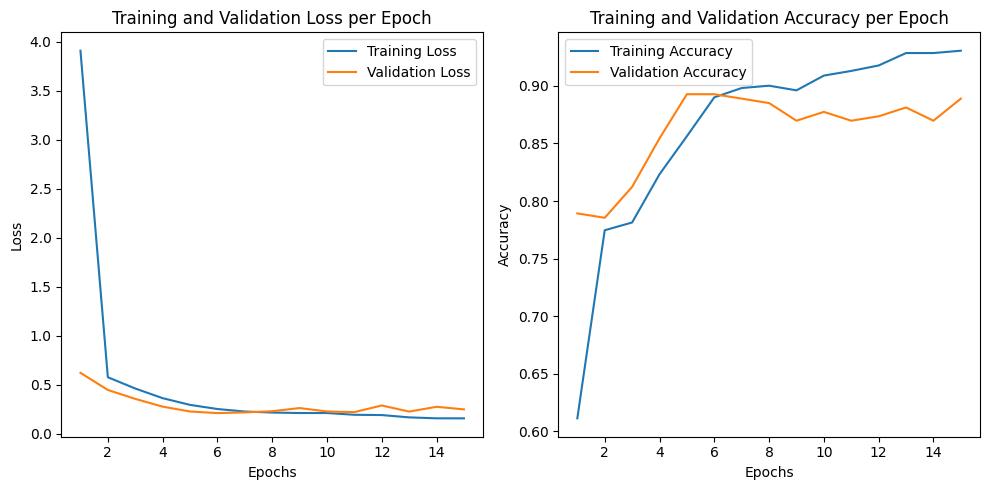

In [54]:
# test_accuracy = test(model=model_, test_loader=test_loader)
plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value, epochs=epochs)

# بخش د

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

input_size = encoded_smiles[0][0].shape[1]
hidden_size = 128
seq_length = 400
output_size = 2
num_layers = 2

epochs = 6

train_acc = []
val_acc = []
test_acc = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split dataset into train and validation sets
    train_set = torch.utils.data.Subset(train_val_dataset, train_idx)
    val_set = torch.utils.data.Subset(train_val_dataset, val_idx)

    # Create dataloaders for train and validation sets
    train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=256, shuffle=False)
    input_size = encoded_smiles[0][0].shape[0] * encoded_smiles[0][0].shape[1]
    
    model_ = LSTMModel(input_size, hidden_size, seq_length, output_size, num_layers, True)
    criterion_ = nn.CrossEntropyLoss()
    optimizer_ = optim.Adam(model_.parameters(), lr=0.01)

    train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value = train(model=model_, train_loader=train_loader,
                                                                                        val_loader=val_loader, epochs=epochs, optimizer=optimizer_,
                                                                                        loss_function=criterion_)
    train_acc.append(train_accuracy_values[-1])
    val_acc.append(val_accuracy_value[-1])
    
    test_accuracy = test(model=model_, test_loader=test_loader)
    test_acc.append(test_accuracy)
    del model_
    torch.cuda.empty_cache()

print(f"train acc = {sum(train_acc)/num_folds}")
print(f"val acc = {sum(val_acc)/num_folds}")
print(f"test acc = {sum(test_acc)/num_folds}")

Fold 1/5
Train Loss: 0.0778, Train Accuracy: 97.85%
Validation Loss: 0.3087, Validation Accuracy: 85.67%
Finished Training
Test Accuracy: 86.32%
Fold 2/5
Train Loss: 0.0846, Train Accuracy: 97.63%
Validation Loss: 0.4062, Validation Accuracy: 84.81%
Finished Training
Test Accuracy: 85.02%
Fold 3/5
Train Loss: 0.0866, Train Accuracy: 97.27%
Validation Loss: 0.3877, Validation Accuracy: 83.38%
Finished Training
Test Accuracy: 85.99%
Fold 4/5
Train Loss: 0.0834, Train Accuracy: 97.99%
Validation Loss: 0.2867, Validation Accuracy: 88.51%
Finished Training
Test Accuracy: 86.32%
Fold 5/5
Train Loss: 0.0903, Train Accuracy: 97.35%
Validation Loss: 0.2869, Validation Accuracy: 87.64%
Finished Training
Test Accuracy: 87.62%
train acc = 0.9761903292657216
val acc = 0.8600352402595263
test acc = 0.8625407166123779


In [ ]:
plot_results(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_value, epochs=epochs)

# بخش ه

تا همین الان تمامی بخش ها مبتنی بر cross validation بوده است.

# بخش و

# بخش ز